# Ensemble Learning 

Aggregating a series of models together helps form a stronger model. As you have have seen in shuffling the DecisionTreeClassifier into smaller models. The group of predictions is called ensemble and the combined group of algorithms is called Ensemble Method. There are several Ensemble Methods, but the following are discussed within this tutorial:
1. Bagging
2. Pasting
3. Out of Bag Evaluation
4. Random Patches
5. Random Subspaces
6. Random Forests
7. Extra Forests
8. AdaBoost
9. Gradient Boosting
10. Stacking

As with the tutorial that used a DecisionTree to manually create a RandomForestClassifier. The predictions of each model is aggregated together to provide the 'most votes' (i.e. mode) also known as <b> hard voting classifier </b>. 


Let's show this using the moons dataset.

# Load Data

In [1]:
from sklearn.datasets import make_moons

data = make_moons(n_samples= 500, noise=0.3, random_state=42)
X= data[0]
y= data[1]

# Split Data

In [2]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)


# Train Diverse Classifiers

Ensemble methods work best when the predictos are as independent from one another as possible. You should train very different algorithms as this increases the chances that they will make very errors, this will help improve the ensemble's accuracy. 

### Hard Voting Classifier
Which obtains the actual prediction. 

In [3]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier #This will help combine the classifiers together
import numpy as np
from sklearn.metrics import accuracy_score
np.random.seed(42)

svc = SVC(gamma= 'scale')
log_clf = LogisticRegression()
forest_clf = RandomForestClassifier(n_estimators=100)

voting_clf = VotingClassifier(
    estimators= [('svc', svc), ('Logistic', log_clf), ('Forest', forest_clf)],
    voting= 'hard')

for clf in (svc, log_clf, forest_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred= clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

SVC 0.896
LogisticRegression 0.864
RandomForestClassifier 0.888
VotingClassifier 0.904


### Soft Voting Classifier
Soft voting uses the highest class <u> probability </u> averaged over all the individual probability classifiers (which is different to hard voting, which uses the mode of the class prediction itself rather then the probability). 

In [4]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier #This will help combine the classifiers together
import numpy as np
from sklearn.metrics import accuracy_score
np.random.seed(42)

svc_prob = SVC(gamma= 'scale', probability= True)#default SVC predicts classes not probabilities
log_clf_prob = LogisticRegression()
forest_clf_prob = RandomForestClassifier(n_estimators=100)

voting_clf_prob = VotingClassifier(
    estimators= [('svc', svc_prob), ('Logistic', log_clf_prob), ('Forest', forest_clf_prob)],
    voting= 'soft')

for clf_prob in (svc_prob, log_clf_prob, forest_clf_prob, voting_clf_prob):
    clf_prob.fit(X_train, y_train)
    y_pred_prob= clf_prob.predict(X_test)
    print(clf_prob.__class__.__name__, accuracy_score(y_test, y_pred_prob))


SVC 0.896
LogisticRegression 0.864
RandomForestClassifier 0.888
VotingClassifier 0.912


# Bagging and Pasting
Another way to obtain better results is to use Bagging or Pasting.

Training the same algorithm over several subsets is beneficial and can help provide a better model. The ensembled model will have similiar bias (Generalization error caused by underfitting) and lower variance (generealization error caused by overfitting) when using bagging/pasting, compared to a single model trained across the entire training data. This is very usful when you wanto train data across a very large dataset.

#### SO what is bagging and pasting?
The subsets can be split by 2 different ways, with replacement (think of it as copying data) and without replacement (the same but cutting the data). 

1. Bagging = aka Boostrap Aggregating = Is when you copy training instances to be sampled across your subsets multiple times to meet the max_samples parameter (i.e. size of the subset training data) that you have set.
2. Pasting - without replacement = is when you create subsets without any replicating instances within any of your subsets. 

Once you have obtained the training models the aggregation function is typically used to combine them. This can either be the statistical mode for classification (i.e. hard voting classification) or average for regression. 

### Fortunetly, we can use Scikit-Learn to do the bulk of the work for us. 

In [5]:
# We need to assign the number of splits per bag - max_samples
# assign the number of classifiers (i.e. models we want to create) - n_estimators
# n_jobs = -1, says use all available cores
# boostrap=True means bagging method while boostrap=False means pasting method

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
                            DecisionTreeClassifier(), n_estimators= 500,
                            max_samples= 100, bootstrap= True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred_bag)


0.904

##### Compare this to just 1 Decision Tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)

tree_clf.fit(X_train, y_train)
y_pred_bag = tree_clf.predict(X_test)

accuracy_score(y_test, y_pred_bag)

0.856

#### Plot a decision boundary to see the difference

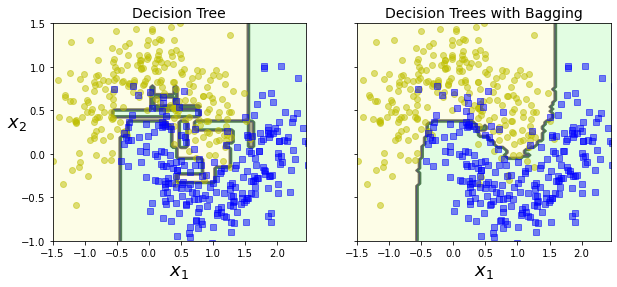

In [7]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    #obtain values for the grid
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    #prediction
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    #assign colours
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    
    #plot lines
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    
    #plot axis and labels
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)


fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

## The right plot generalizes signifcantly better compared to the single decision tree. 

Generally, it is better to use bootstrapping as it has adds more diversity within the subsets. However, if CPU power permits then you should try use Cross Validation to evaluate both bagging and pasting, and choose one that works best.

Interestingly, when reading: http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf, it is preferred using 10 fold (stratified) cross validation compared to bootstrap. The journal states that although variance tends to be less, the bias ends up being signifcantly large for some datasets. 

When using bagging (boostrap or pasting) for a given predictor, some samples may not be used for preditions at all ~ 37% of them (formly called out of bag (OOB) instances), while the remaining 63% will randomly be used in each bag to train that model.<b> Wait! </b> We can use the OOB instances to validate each bag's model. Setting oob_score= True does this. This makes it possible for a fairly unbiased evaluation of the ensemble and gives an additional validation set.

In [8]:
from sklearn.ensemble import BaggingClassifier

bag_clf_oob = BaggingClassifier(DecisionTreeClassifier(), random_state=42, oob_score= True, n_estimators=500,
                                bootstrap=True, n_jobs=-1)

bag_clf_oob.fit(X_train, y_train)

bag_clf_oob.oob_score_

0.8986666666666666

###### This score essentially gives us a prediction of the accuracy score that we may see during testing. See below.
We achieved a better score during the Validation set.

In [9]:
y_pred_oob = bag_clf_oob.predict(X_test)
accuracy_score(y_test, y_pred_oob)

0.912

#### So far we have only see bootsrap on instances. We can also use it on features by setting the 2 hyperparameters:
- max_features = <1.0
- bootstrap_features = True

Both methods train the subset of data on a random set of features. This is very useful when dealing with a high number of features. 

#### Combining the two together, when you sample the data and features is called <u> Random Patches Method </u>. 

#### When you just want to sample the features that is called <u> Random Subspaces Method </u>, you can do this by 'turning off' the instances bagging and turning on the features, see hyperparameter settings below. The Subspaces method psuedorandomly selects subsets of components of the feature vector itself (for some reason that I do not understand this procedure works!)
#turn off instance bagging
- bootstrap= False
- max_samples= 1.0

#turn on feature sampling
- max_features = <1.0
- boostrap_features= True



# Random Forests
Decision trees work really well with training data but may lack in accuracy for new instances. The random forest creates internal nodes that are randomly assigned until a classification is output. This is multiplied several times to make a forest where each decision tree is different, where it searches for the best feature among a random subset of features; moreover, this gives greater tree diversity. Therefore, higher bias for lower variance. 

<i> note, decision trees search for the best feature NOT a random feature. </i>

We used the BaggingClassifier class and input the DecisionTreeClassifier to help us build a decision tree. Instead, we can use the RandomForestClassifier class which is optimised for DecisionTrees. The following codes shows improvements from the previous BaggingClassifier oob and accuracy scores.

<i> BaggingClassifier can input other types of classifiers </i>

In [10]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(random_state=42, oob_score= True, n_estimators=500,
                                bootstrap=True, n_jobs=-1, max_leaf_nodes=16)
#typically max_samples is set to the size of the training set
random_forest_clf.fit(X_train, y_train)

y_pred_random_forest = random_forest_clf.predict(X_test)

print('Random Forest Out of Bag Score: ', random_forest_clf.oob_score_)
print('Random Forest Accuracy Score', accuracy_score(y_test, y_pred_random_forest))


Random Forest Out of Bag Score:  0.9173333333333333
Random Forest Accuracy Score 0.912


# Extra Tree Classifier
We can make trees even more random by assigning a random threshold for each feature rather than searching for the best threshold value like regular decision trees. This is called Extremely Randomized Trees - Extra Trees for short. 

This introduces more bias but a lower variance. It also trains faster then random forest since we are assigning a random value. But it <u> predicts</u> at the same rate as RandomForests. 

In [11]:
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_clf = ExtraTreesClassifier(random_state=42, oob_score= True, n_estimators=500,
                                bootstrap=True, n_jobs=-1, max_leaf_nodes=16)

extra_tree_clf.fit(X_train, y_train)

y_pred_extra_tree_clf = extra_tree_clf.predict(X_test)

print('Extra Tree Out of Bag Score: ', extra_tree_clf.oob_score_)
print('Extra Tree Accuracy Score', accuracy_score(y_test, y_pred_extra_tree_clf))

Extra Tree Out of Bag Score:  0.8986666666666666
Extra Tree Accuracy Score 0.912


#### Similiar results are obtained.

# Be sure to try both using Cross Validation and then tune hyperparameters using GridSearch

# Feature Importance
This is calculated by the forest tree nodes that use a given feature and reduce impurity on average. (i.e. A nodes weight = number of training samples).
Following this, Sklearn outputs the weighted average (i.e. %) of each features importance using the feature_importance_ variable.  

In [12]:
#load iris
from sklearn.datasets import load_iris
iris = load_iris()
X = iris['data']
y = iris['target']

#note we should split the data but I just want to show what feature importance's output is
#train model
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)

for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)
    
# as you can see the Petal Length and Petal width are really import features while Sepal length and width are not. 

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


# Hypothesis Boosting - Adaboost and Gradient Boosting

Why don't we train models sequentially? Where the next model improves based on the previous model's performance. 

There are two most popular are
1. Adaboost - uses the <u> weighted error rate </u>, updates it using the weight update rule and then based on the all the predictions, it uses the majority of weighted votes to make prediction. The weighted errors are updated simultaneously instead of updating a single parameter like Gradient Descent.  
 <i> SVC tend to be unstable with Adaboost. Adaboost does not scale as well as bagging and pasting.  </i>

In plain English, there are a series of (yes or no) trees followed by some maths to see which tree is relevant then finds the mode of the predictions to use a the instance's prediction. A Video might help explain this then words: https://www.youtube.com/watch?v=LsK-xG1cLYA&t=848s 

Adaboost can also perform multiclasses using SAMME (Stagewise Addictive Modelling using a Multiclass Exponential Loss Function). If a classifier is used that has the predict_proba method (i.e. probabilities) then you should assign algorithm= 'SAMME.R' as this relies on class probabilities(rather than class predictions) and <b> generally performs better </b>.

If Adaboost is underfitting you can try increasing the n_estimators (stumps) and the learning_rate, and reducing the base estimator (for example, max_depth or min_samples_split etc.). 

2. Gradient Boosting - Uses the <u> residual errors </u> to tweak a new predictor. Initially, a model is produced and the residual error is calculated (h(x) - y). This value then determines the next model's prediction, where the residual error is calculate for the second model $(h(x)^2 - y)$ using $h_{average}(x) + a * (h(x) -y)$ at which point you will see an improved model where alpha is the learning rate. If you keep doing this you will see the model has approved based on the residual errors where each subsequent model increments your prediction in right direction.  

If you are overftting the training data then you should try reduce the learning rate and use early stopping because it is likely you are using too many predictors.

XGBoost is a key package to help implement Gradient Boosting and has been involved in winning several competitions. You will see high bias but a low variance in your model.


In [13]:
#Example of AdaBoost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=42, n_estimators= 200,
                             algorithm= 'SAMME.R', learning_rate= 0.5)
ada_clf.fit(X_train, y_train)
y_predict_ada = ada_clf.predict(X_test)

print('DecisionTree Adaboost Accuracy Score', accuracy_score(y_test, y_predict_ada))

DecisionTree Adaboost Accuracy Score 0.896


In [14]:
#Example of Gradient Boost - when used with Decision Trees it is called GBRT - Gradient Boosted Regression Trees

from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=42, max_depth= 2, n_estimators= 3, learning_rate= 0.1)
gbrt.fit(X_train, y_train)

y_pred_boost = gbrt.predict(X_test)

print('DecisionTree Gradient Boost Accuracy Score', accuracy_score(y_test, y_pred_boost))

#The Learning rate scales the contribution of each tree, a lower value means it will generalise better, this is called
#Shrinkage. But making the value, like with everything we have learnt to far, too small will cause introduce bias errors.

DecisionTree Gradient Boost Accuracy Score 0.896


#### Interestingly,  the score is the same as AdaBoost. But this may not always be the case. 

### With Gradient Boosting, the problem is that you need to find the optimal number of trees, to do this you can use early stopping. 
Instead of trying to train all the trees and then calculate the scores for each tree, we can incorporate early stopping by setting warm_start= True to stop once validation error does reduce any further for m iterations in a row. 

In [15]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingClassifier(random_state=42, warm_start= True,
                                  max_depth=2,)# subsample=0.25 is referred to as Stochastic Gradient Boosting,
#it introduces a higher bias, for lower variance. As it is trained on 25% of the training instances.
    

min_val_error = float('inf') #highest possible value of error.

for i in range(1, 120):
    gbrt.n_estimators = i
    gbrt.fit(X_train, y_train)
    y_pred_gbrt = gbrt.predict(X_test)
    test_error = mean_squared_error(y_test, y_pred_gbrt)
    if test_error<min_val_error:
        min_val_error= test_error
        error_going_up = 0
    else:
        error_going_up=+1
        if error_going_up==5:
            break
print(test_error)
print('DecisionTree Gradient Boost Early Stopping Accuracy Score', accuracy_score(y_test, y_pred_gbrt))

0.104
DecisionTree Gradient Boost Early Stopping Accuracy Score 0.896


# Stacking
The final Ensembled method discussed is stacking (Stacked Generalization) where a series of models are combined and evaluated. Each model's predictions are used as an input for the 'blender' model, which is the final predictor, that makes a final prediction based on the other models output. 

The blender model (also known as the meta learner) aggregates outputs to help reduce the generalization error rate. A simple version of aggregation is that used in hard voting (i.e. the mode) but stacking provides a more sophisticated approach. 

The Stacking approach seems to be similiar to Neural Networks.
Sklearn does not have Stacking but you can try create our own. 